In [1]:
# Install required packages
!pip install textblob nltk flair transformers torch pandas numpy matplotlib seaborn scikit-learn

In [2]:
!pip install tensorflow==2.15.0 keras==2.15.0
!pip install --upgrade transformers

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# For model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the datasets
emotions_df = pd.read_csv('/Users/ishitagupta/Library/CloudStorage/OneDrive-Personal/[02] BITS Pilani M Tech Software Systems/[04] Semester 4/[02] SSZG628 - Dissertation/Code Execution/Dataset/Emotions/emotions.csv')
amazon_df = pd.read_csv('/Users/ishitagupta/Library/CloudStorage/OneDrive-Personal/[02] BITS Pilani M Tech Software Systems/[04] Semester 4/[02] SSZG628 - Dissertation/Code Execution/Dataset/Sentiment Analysis labelled/amazon_reviews_with_emotions.csv')

# Display basic information about the datasets
print("Amazon Reviews Dataset:")
print(amazon_df.shape)
print(amazon_df.columns.tolist())
print("\nAmazon Reviews Sample:")
print(amazon_df.head(3))

print("\nEmotions Dataset:")
print(emotions_df.shape)
print(emotions_df.columns.tolist())
print("\nEmotions Sample:")
print(emotions_df.head(3))

Amazon Reviews Dataset:
(4915, 13)
['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'sentimentAnalysisCode']

Amazon Reviews Sample:
   Unnamed: 0 reviewerName  overall  \
0           0          NaN      4.0   
1           1         0mie      5.0   
2           2          1K3      4.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0                   0   

   s

In [5]:
# Check for missing values
print("Missing values in Amazon Reviews:")
print(amazon_df.isnull().sum())

print("\nMissing values in Emotions Dataset:")
print(emotions_df.isnull().sum())

# Review distribution by rating in Amazon dataset
print("\nDistribution of ratings in Amazon dataset:")
print(amazon_df['overall'].value_counts().sort_index())

# Check sentiment distribution in Amazon dataset
print("\nDistribution of sentiments in Amazon dataset:")
print(amazon_df['sentimentAnalysisCode'].value_counts())

# Check emotions distribution in emotions dataset
print("\nDistribution of emotions in emotions dataset:")
print(emotions_df['label'].value_counts())

Missing values in Amazon Reviews:
Unnamed: 0               0
reviewerName             1
overall                  0
reviewText               1
reviewTime               0
day_diff                 0
helpful_yes              0
helpful_no               0
total_vote               0
score_pos_neg_diff       0
score_average_rating     0
wilson_lower_bound       0
sentimentAnalysisCode    0
dtype: int64

Missing values in Emotions Dataset:
text     0
label    0
dtype: int64

Distribution of ratings in Amazon dataset:
overall
1.0     244
2.0      80
3.0     142
4.0     527
5.0    3922
Name: count, dtype: int64

Distribution of sentiments in Amazon dataset:
sentimentAnalysisCode
1    4782
0     130
4       2
3       1
Name: count, dtype: int64

Distribution of emotions in emotions dataset:
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


In [6]:
# Prepare Amazon data for sentiment analysis
amazon_reviews = amazon_df[['reviewText', 'sentimentAnalysisCode']].copy()
amazon_reviews = amazon_reviews.dropna() # Remove rows with missing reviews

# Mapping for sentiment analysis codes (if needed)
# Based on the sample data, we see values like 0, 1, 3, 4
# We'll treat this as binary for now (negative vs positive)
# We'll confirm the actual distribution first

print("Unique sentiment analysis codes:")
print(amazon_reviews['sentimentAnalysisCode'].unique())

# Convert sentiment codes to binary (0: negative, 1: positive)
# This is an assumption - we may need to adjust based on the actual data
amazon_reviews['binary_sentiment'] = amazon_reviews['sentimentAnalysisCode'].apply(
    lambda x: 1 if x > 2 else 0)

print("\nDistribution of binary sentiment:")
print(amazon_reviews['binary_sentiment'].value_counts())

Unique sentiment analysis codes:
[1 0 3 4]

Distribution of binary sentiment:
binary_sentiment
0    4911
1       3
Name: count, dtype: int64


In [7]:
# TextBlob
from textblob import TextBlob

def analyze_sentiment_textblob(text):
    try:
        # Get polarity score (-1 to 1)
        polarity = TextBlob(text).sentiment.polarity
        # Convert to binary (0: negative, 1: positive)
        return 1 if polarity >= 0 else 0
    except:
        return None

In [8]:
# VADER (Valence Aware Dictionary and sEntiment Reasoner)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon', quiet=True)

def analyze_sentiment_vader(text):
    try:
        sid = SentimentIntensityAnalyzer()
        sentiment_scores = sid.polarity_scores(text)
        # Convert to binary based on compound score
        return 1 if sentiment_scores['compound'] >= 0 else 0
    except:
        return None

In [9]:
# Flair
from flair.models import TextClassifier
from flair.data import Sentence

# Load sentiment classifier
flair_sentiment = TextClassifier.load('en-sentiment')

def analyze_sentiment_flair(text):
    try:
        # Create a sentence
        sentence = Sentence(text)
        # Predict sentiment
        flair_sentiment.predict(sentence)
        # Extract sentiment label (POSITIVE or NEGATIVE)
        label = sentence.labels[0].value
        # Convert to binary
        return 1 if label == 'POSITIVE' else 0
    except:
        
        return None

In [10]:
# DistilBERT using Hugging Face's Transformers
from transformers import pipeline

# Load sentiment analysis pipeline
distilbert_sentiment = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

def analyze_sentiment_distilbert(text):
    try:
        # Get sentiment (POSITIVE or NEGATIVE)
        result = distilbert_sentiment(text[:512])[0]  # Limit text length for DistilBERT
        # Convert to binary
        return 1 if result['label'] == 'POSITIVE' else 0
    except:
        return None

In [11]:
# BERT using Hugging Face's Transformers
bert_sentiment = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

def analyze_sentiment_bert(text):
    try:
        # This model returns rating from 1-5
        result = bert_sentiment(text[:512])[0]
        rating = int(result['label'].split()[0])
        # Convert to binary (ratings 1-2: negative, 3-5: positive)
        return 1 if rating > 2 else 0
    except:
        return None

In [12]:
# Create a sample for faster testing
# Using 100 samples for quick evaluation
sample_size = 100
amazon_sample = amazon_reviews.sample(sample_size, random_state=42)

# Dictionary to store results
results = {}
inference_times = {}

# Apply TextBlob
start_time = time.time()
amazon_sample['textblob_sentiment'] = amazon_sample['reviewText'].apply(analyze_sentiment_textblob)
inference_times['TextBlob'] = (time.time() - start_time) / sample_size
results['TextBlob'] = amazon_sample['textblob_sentiment']

# Apply VADER
start_time = time.time()
amazon_sample['vader_sentiment'] = amazon_sample['reviewText'].apply(analyze_sentiment_vader)
inference_times['VADER'] = (time.time() - start_time) / sample_size
results['VADER'] = amazon_sample['vader_sentiment']

# Apply Flair (this might be slower)
start_time = time.time()
amazon_sample['flair_sentiment'] = amazon_sample['reviewText'].apply(analyze_sentiment_flair)
inference_times['Flair'] = (time.time() - start_time) / sample_size
results['Flair'] = amazon_sample['flair_sentiment']

# Apply DistilBERT (this will be slower)
start_time = time.time()
amazon_sample['distilbert_sentiment'] = amazon_sample['reviewText'].apply(analyze_sentiment_distilbert)
inference_times['DistilBERT'] = (time.time() - start_time) / sample_size
results['DistilBERT'] = amazon_sample['distilbert_sentiment']

# Apply BERT (this will be slower)
start_time = time.time()
amazon_sample['bert_sentiment'] = amazon_sample['reviewText'].apply(analyze_sentiment_bert)
inference_times['BERT'] = (time.time() - start_time) / sample_size
results['BERT'] = amazon_sample['bert_sentiment']

# Print inference times
print("Average inference time per review (seconds):")
for model, time_taken in inference_times.items():
    print(f"{model}: {time_taken:.4f} seconds")

Average inference time per review (seconds):
TextBlob: 0.0006 seconds
VADER: 0.0028 seconds
Flair: 0.0258 seconds
DistilBERT: 0.0321 seconds
BERT: 0.0268 seconds


In [13]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Inference Time': inference_times[model_name]
    }

# Dictionary to store evaluation results
eval_results = []

# Evaluate each model
for model_name, predictions in results.items():
    result = evaluate_model(amazon_sample['binary_sentiment'], predictions, model_name)
    eval_results.append(result)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(eval_results)
print("\nModel Comparison:")
print(comparison_df.set_index('Model'))


TextBlob Performance:
Accuracy: 0.0800
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

VADER Performance:
Accuracy: 0.1400
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Flair Performance:
Accuracy: 0.1600
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

DistilBERT Performance:
Accuracy: 0.3100
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

BERT Performance:
Accuracy: 0.1000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Model Comparison:
            Accuracy  Precision  Recall  F1 Score  Inference Time
Model                                                            
TextBlob        0.08        0.0     0.0       0.0        0.000557
VADER           0.14        0.0     0.0       0.0        0.002789
Flair           0.16        0.0     0.0       0.0        0.025789
DistilBERT      0.31        0.0     0.0       0.0        0.032062
BERT            0.10        0.0     0.0       0.0        0.026795


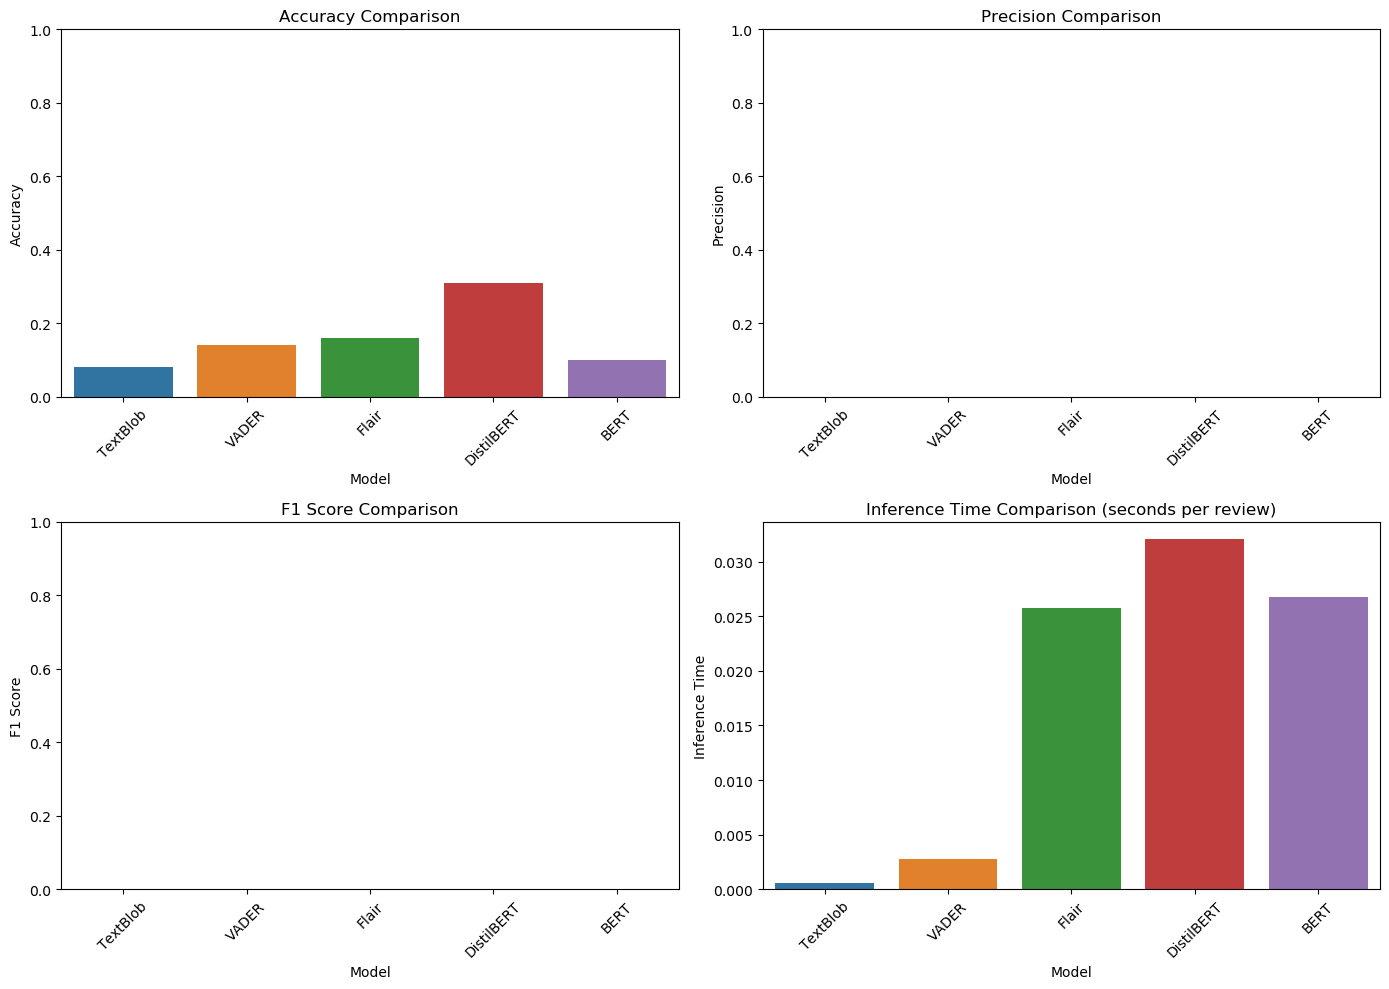

In [14]:
# Set up the figure
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=comparison_df)
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot F1 Score
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='F1 Score', data=comparison_df)
plt.title('F1 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot Inference Time
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Inference Time', data=comparison_df)
plt.title('Inference Time Comparison (seconds per review)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

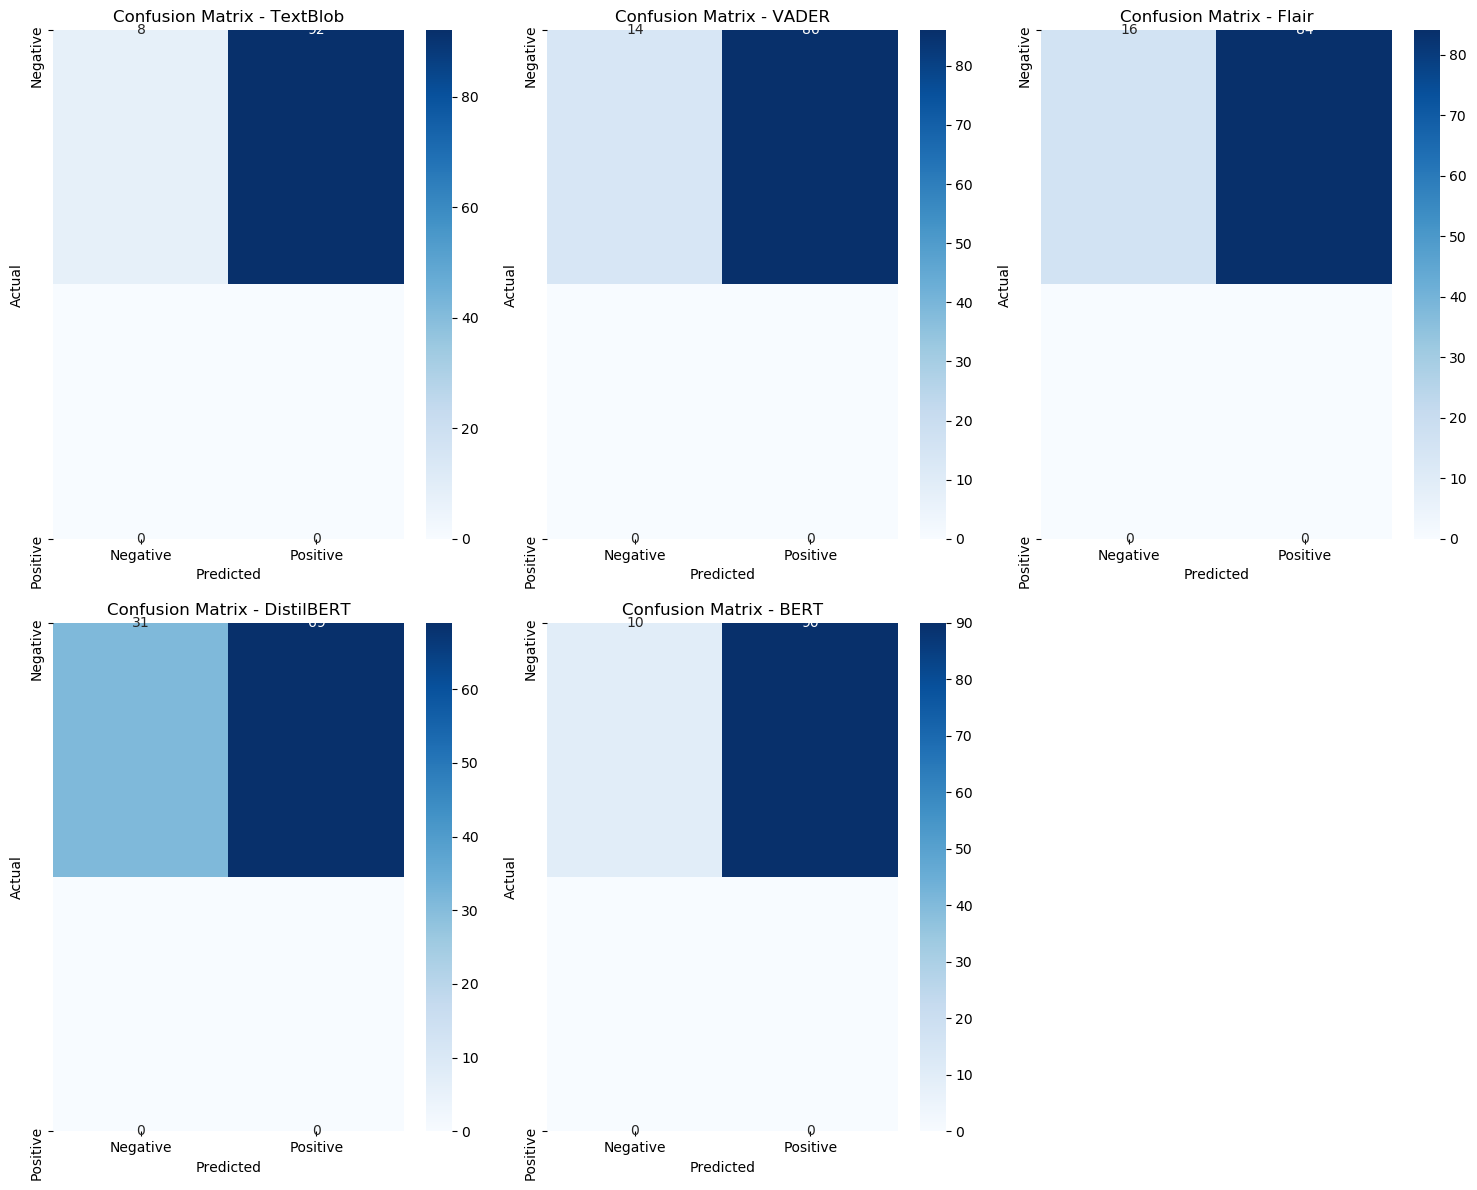

In [15]:
# Plot confusion matrices
plt.figure(figsize=(15, 12))
models = list(results.keys())

for i, model_name in enumerate(models):
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(amazon_sample['binary_sentiment'], results[model_name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [16]:
# Let's apply our sentiment analysis models on the emotions dataset
# For simplicity, we'll convert the 6 emotion categories to binary sentiment
# Typically: sadness(0), fear(4) -> negative; joy(1), love(2), surprise(5) -> positive
# Anger(3) is typically negative but could be context-dependent

emotions_df['binary_sentiment'] = emotions_df['label'].apply(
    lambda x: 0 if x in [0, 4] else 1  # Simplistic mapping
)

# Sample for faster processing
emotions_sample = emotions_df.sample(min(len(emotions_df), 100), random_state=42)

# Apply models to emotions dataset
emotions_results = {}
emotions_inference_times = {}

# Apply TextBlob
start_time = time.time()
emotions_sample['textblob_sentiment'] = emotions_sample['text'].apply(analyze_sentiment_textblob)
emotions_inference_times['TextBlob'] = (time.time() - start_time) / len(emotions_sample)
emotions_results['TextBlob'] = emotions_sample['textblob_sentiment']

# Apply VADER
start_time = time.time()
emotions_sample['vader_sentiment'] = emotions_sample['text'].apply(analyze_sentiment_vader)
emotions_inference_times['VADER'] = (time.time() - start_time) / len(emotions_sample)
emotions_results['VADER'] = emotions_sample['vader_sentiment']

# Apply Flair
start_time = time.time()
emotions_sample['flair_sentiment'] = emotions_sample['text'].apply(analyze_sentiment_flair)
emotions_inference_times['Flair'] = (time.time() - start_time) / len(emotions_sample)
emotions_results['Flair'] = emotions_sample['flair_sentiment']

# Apply DistilBERT
start_time = time.time()
emotions_sample['distilbert_sentiment'] = emotions_sample['text'].apply(analyze_sentiment_distilbert)
emotions_inference_times['DistilBERT'] = (time.time() - start_time) / len(emotions_sample)
emotions_results['DistilBERT'] = emotions_sample['distilbert_sentiment']

# Apply BERT
start_time = time.time()
emotions_sample['bert_sentiment'] = emotions_sample['text'].apply(analyze_sentiment_bert)
emotions_inference_times['BERT'] = (time.time() - start_time) / len(emotions_sample)
emotions_results['BERT'] = emotions_sample['bert_sentiment']

# Evaluate on emotions dataset
emotions_eval_results = []

for model_name, predictions in emotions_results.items():
    result = {
        'Model': model_name,
        'Accuracy': accuracy_score(emotions_sample['binary_sentiment'], predictions),
        'Precision': precision_score(emotions_sample['binary_sentiment'], predictions, zero_division=0),
        'Recall': recall_score(emotions_sample['binary_sentiment'], predictions, zero_division=0),
        'F1 Score': f1_score(emotions_sample['binary_sentiment'], predictions, zero_division=0),
        'Inference Time': emotions_inference_times[model_name]
    }
    emotions_eval_results.append(result)

# Create a DataFrame for comparison
emotions_comparison_df = pd.DataFrame(emotions_eval_results)
print("\nModel Comparison on Emotions Dataset:")
print(emotions_comparison_df.set_index('Model'))


Model Comparison on Emotions Dataset:
            Accuracy  Precision    Recall  F1 Score  Inference Time
Model                                                              
TextBlob        0.60   0.607143  0.653846  0.629630        0.000065
VADER           0.65   0.673469  0.634615  0.653465        0.002517
Flair           0.67   0.771429  0.519231  0.620690        0.016506
DistilBERT      0.68   0.794118  0.519231  0.627907        0.017734
BERT            0.67   0.679245  0.692308  0.685714        0.017103


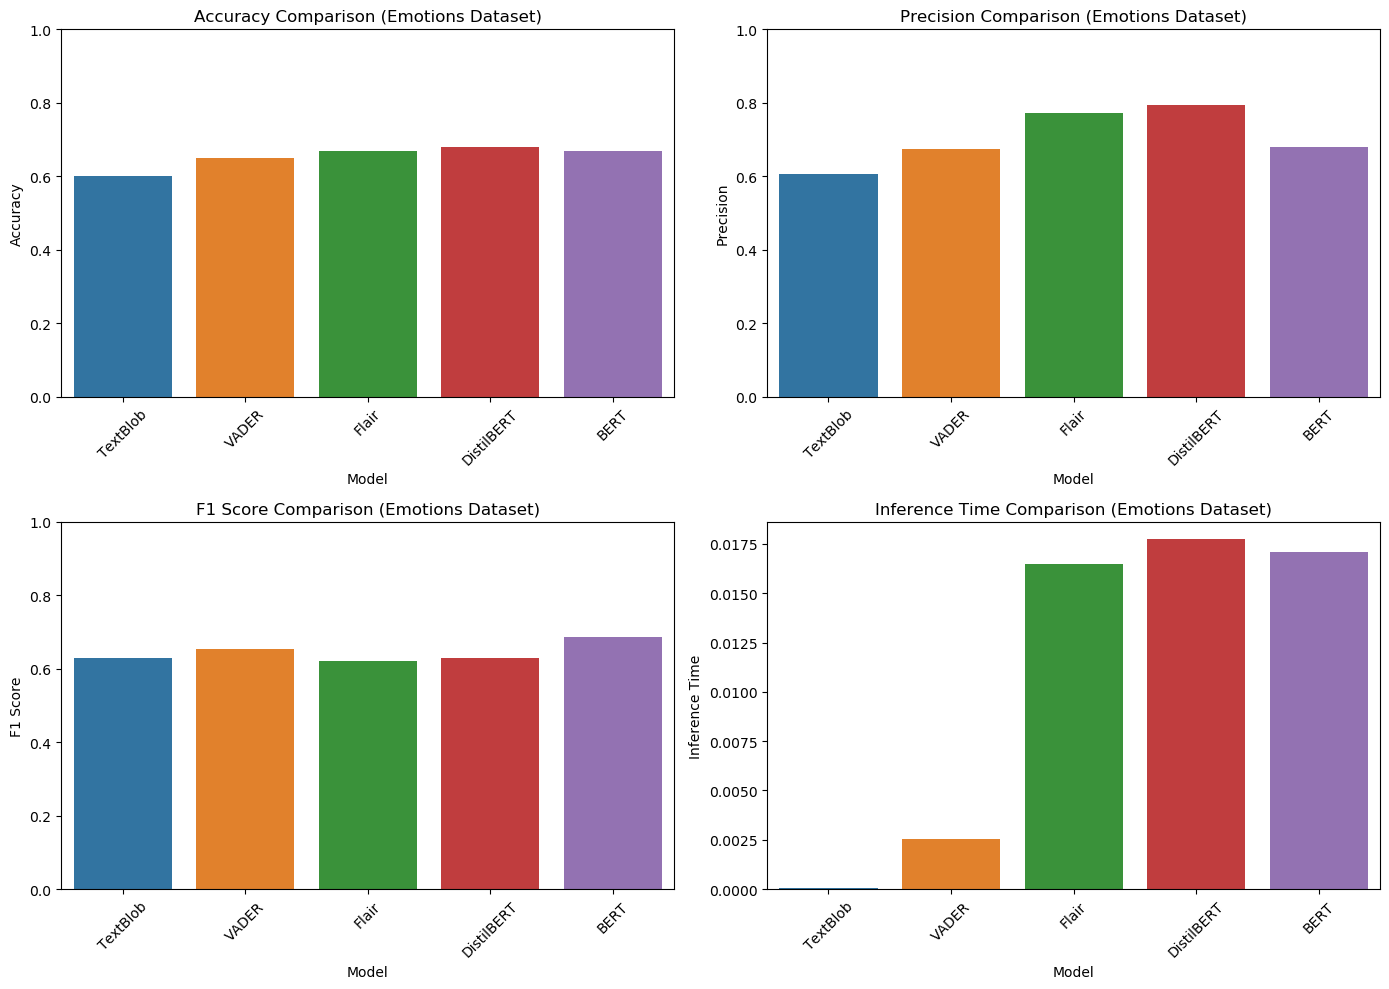

In [17]:
# Visualization for emotions dataset results
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=emotions_comparison_df)
plt.title('Accuracy Comparison (Emotions Dataset)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=emotions_comparison_df)
plt.title('Precision Comparison (Emotions Dataset)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot F1 Score
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='F1 Score', data=emotions_comparison_df)
plt.title('F1 Score Comparison (Emotions Dataset)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot Inference Time
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Inference Time', data=emotions_comparison_df)
plt.title('Inference Time Comparison (Emotions Dataset)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

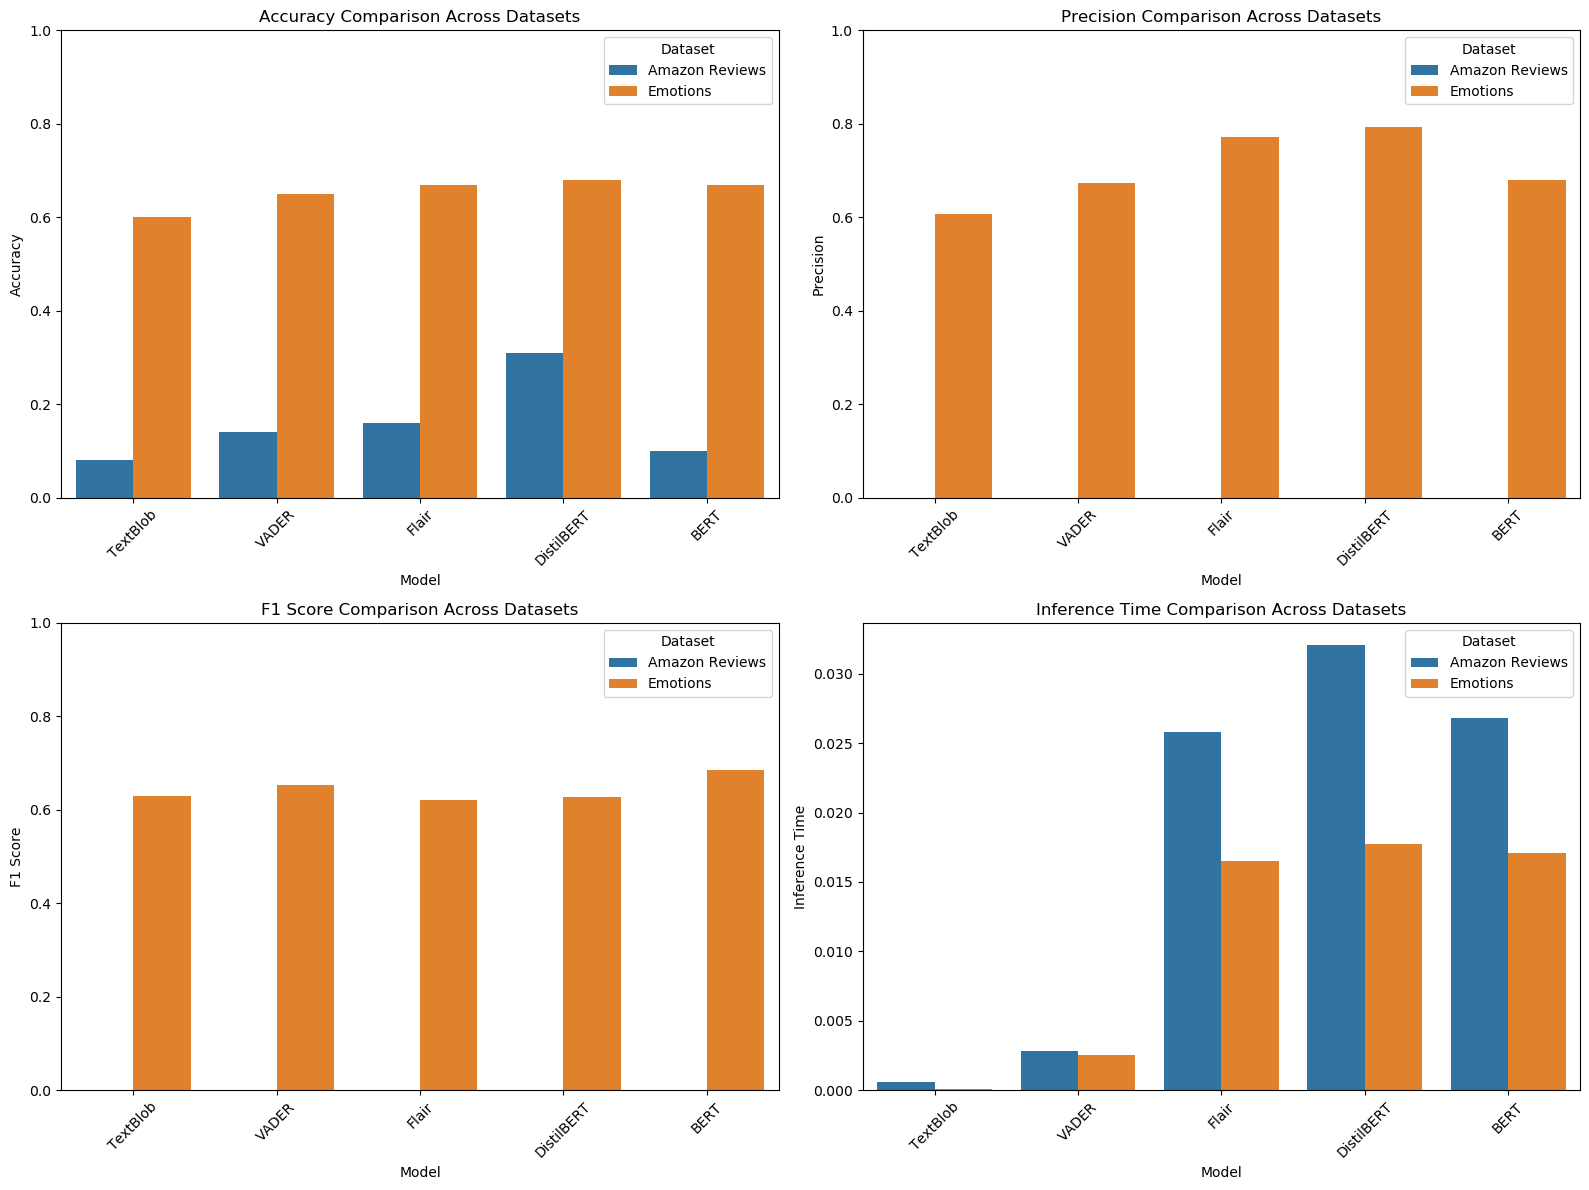


Summary of Model Performance:
        Model         Dataset  Accuracy  Precision  F1 Score  Inference Time
0        BERT  Amazon Reviews      0.10   0.000000  0.000000        0.026795
1        BERT        Emotions      0.67   0.679245  0.685714        0.017103
2  DistilBERT  Amazon Reviews      0.31   0.000000  0.000000        0.032062
3  DistilBERT        Emotions      0.68   0.794118  0.627907        0.017734
4       Flair  Amazon Reviews      0.16   0.000000  0.000000        0.025789
5       Flair        Emotions      0.67   0.771429  0.620690        0.016506
6    TextBlob  Amazon Reviews      0.08   0.000000  0.000000        0.000557
7    TextBlob        Emotions      0.60   0.607143  0.629630        0.000065
8       VADER  Amazon Reviews      0.14   0.000000  0.000000        0.002789
9       VADER        Emotions      0.65   0.673469  0.653465        0.002517

Best Models:
Best Accuracy: DistilBERT (Amazon Reviews) - 0.3100
Best Precision: DistilBERT (Amazon Reviews) - 0.0000
Bes

In [18]:
# Combine the results from both datasets
amazon_comparison_df = comparison_df.copy()
amazon_comparison_df['Dataset'] = 'Amazon Reviews'
emotions_comparison_df['Dataset'] = 'Emotions'
combined_df = pd.concat([amazon_comparison_df, emotions_comparison_df])

# Create a figure for the combined comparison
plt.figure(figsize=(16, 12))

# Plot accuracy for both datasets
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=combined_df)
plt.title('Accuracy Comparison Across Datasets')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot precision for both datasets
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', hue='Dataset', data=combined_df)
plt.title('Precision Comparison Across Datasets')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot F1 Score for both datasets
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='F1 Score', hue='Dataset', data=combined_df)
plt.title('F1 Score Comparison Across Datasets')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot Inference Time for both datasets
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Inference Time', hue='Dataset', data=combined_df)
plt.title('Inference Time Comparison Across Datasets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary of Model Performance:")
summary = combined_df.groupby(['Model', 'Dataset']).mean().reset_index()
print(summary[['Model', 'Dataset', 'Accuracy', 'Precision', 'F1 Score', 'Inference Time']])

# Get the best model for each metric
best_accuracy_idx = combined_df['Accuracy'].idxmax()
best_precision_idx = combined_df['Precision'].idxmax()
best_f1_idx = combined_df['F1 Score'].idxmax()
fastest_idx = combined_df['Inference Time'].idxmin()

best_accuracy = combined_df.iloc[best_accuracy_idx]
best_precision = combined_df.iloc[best_precision_idx]
best_f1 = combined_df.iloc[best_f1_idx]
fastest = combined_df.iloc[fastest_idx]

print("\nBest Models:")
print(f"Best Accuracy: {best_accuracy['Model']} ({best_accuracy['Dataset']}) - {best_accuracy['Accuracy']:.4f}")
print(f"Best Precision: {best_precision['Model']} ({best_precision['Dataset']}) - {best_precision['Precision']:.4f}")
print(f"Best F1 Score: {best_f1['Model']} ({best_f1['Dataset']}) - {best_f1['F1 Score']:.4f}")
print(f"Fastest: {fastest['Model']} ({fastest['Dataset']}) - {fastest['Inference Time']:.4f} seconds")

In [19]:
# Calculate an overall score
combined_df['Overall_Score'] = (
    combined_df['Accuracy'] * 0.4 + 
    combined_df['F1 Score'] * 0.4 + 
    (1 / (combined_df['Inference Time'] + 0.01)) * 0.2  # Inverse of inference time
)

# Get best overall model using iloc to ensure we get just one row
best_overall_idx = combined_df['Overall_Score'].idxmax()
best_overall = combined_df.iloc[best_overall_idx]

print("\nRecommended Model Based on Overall Performance:")
print(f"Model: {best_overall['Model']}")
print(f"Dataset: {best_overall['Dataset']}")
print(f"Accuracy: {best_overall['Accuracy']:.4f}")
print(f"Precision: {best_overall['Precision']:.4f}")
print(f"F1 Score: {best_overall['F1 Score']:.4f}")
print(f"Inference Time: {best_overall['Inference Time']:.4f} seconds")
print(f"Overall Score: {best_overall['Overall_Score']:.4f}")


Recommended Model Based on Overall Performance:
Model: TextBlob
Dataset: Amazon Reviews
Accuracy: 0.0800
Precision: 0.0000
F1 Score: 0.0000
Inference Time: 0.0006 seconds
Overall Score: 18.9761


In [25]:
# Load the new Amazon reviews dataset
new_amazon_df = pd.read_csv('/Users/ishitagupta/Library/CloudStorage/OneDrive-Personal/[02] BITS Pilani M Tech Software Systems/[04] Semester 4/[02] SSZG628 - Dissertation/Code Execution/Dataset/Sentiment Analysis labelled/amazon_reviews.csv')

# Display basic information about the new dataset
print("\nNew Amazon Reviews Dataset:")
print(new_amazon_df.shape)
print(new_amazon_df.columns.tolist())
print("\nNew Amazon Reviews Sample:")
print(new_amazon_df.head(3))

# Check for missing values
print("\nMissing values in New Amazon Reviews:")
print(new_amazon_df.isnull().sum())

# Check sentiment distribution in new Amazon dataset
print("\nDistribution of sentiments in new Amazon dataset:")
print(new_amazon_df['Label'].value_counts())


New Amazon Reviews Dataset:
(400000, 2)
['Review', 'Label']

New Amazon Reviews Sample:
                                              Review  Label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0

Missing values in New Amazon Reviews:
Review    0
Label     0
dtype: int64

Distribution of sentiments in new Amazon dataset:
Label
1    200000
0    200000
Name: count, dtype: int64


In [26]:
# Prepare new Amazon data for sentiment analysis
new_amazon_reviews = new_amazon_df[['Review', 'Label']].copy()
new_amazon_reviews = new_amazon_reviews.dropna()  # Remove rows with missing reviews

# Create a sample for faster testing
sample_size = 100
new_amazon_sample = new_amazon_reviews.sample(sample_size, random_state=42)

# Dictionary to store results for new dataset
new_results = {}
new_inference_times = {}

# Apply TextBlob
start_time = time.time()
new_amazon_sample['textblob_sentiment'] = new_amazon_sample['Review'].apply(analyze_sentiment_textblob)
new_inference_times['TextBlob'] = (time.time() - start_time) / sample_size
new_results['TextBlob'] = new_amazon_sample['textblob_sentiment']

# Apply VADER
start_time = time.time()
new_amazon_sample['vader_sentiment'] = new_amazon_sample['Review'].apply(analyze_sentiment_vader)
new_inference_times['VADER'] = (time.time() - start_time) / sample_size
new_results['VADER'] = new_amazon_sample['vader_sentiment']

# Apply Flair
start_time = time.time()
new_amazon_sample['flair_sentiment'] = new_amazon_sample['Review'].apply(analyze_sentiment_flair)
new_inference_times['Flair'] = (time.time() - start_time) / sample_size
new_results['Flair'] = new_amazon_sample['flair_sentiment']

# Apply DistilBERT
start_time = time.time()
new_amazon_sample['distilbert_sentiment'] = new_amazon_sample['Review'].apply(analyze_sentiment_distilbert)
new_inference_times['DistilBERT'] = (time.time() - start_time) / sample_size
new_results['DistilBERT'] = new_amazon_sample['distilbert_sentiment']

# Apply BERT
start_time = time.time()
new_amazon_sample['bert_sentiment'] = new_amazon_sample['Review'].apply(analyze_sentiment_bert)
new_inference_times['BERT'] = (time.time() - start_time) / sample_size
new_results['BERT'] = new_amazon_sample['bert_sentiment']

# Dictionary to store evaluation results
new_eval_results = []

# Evaluate each model on the new dataset
for model_name, predictions in new_results.items():
    result = evaluate_model(new_amazon_sample['Label'], predictions, model_name)
    result['Inference Time'] = new_inference_times[model_name]
    new_eval_results.append(result)

# Create a DataFrame for comparison of the new dataset
new_comparison_df = pd.DataFrame(new_eval_results)
print("\nModel Comparison on New Amazon Reviews Dataset:")
print(new_comparison_df.set_index('Model'))


TextBlob Performance:
Accuracy: 0.6700
Precision: 0.6026
Recall: 0.9592
F1 Score: 0.7402

VADER Performance:
Accuracy: 0.7200
Precision: 0.6615
Recall: 0.8776
F1 Score: 0.7544

Flair Performance:
Accuracy: 0.9400
Precision: 0.9778
Recall: 0.8980
F1 Score: 0.9362

DistilBERT Performance:
Accuracy: 0.9400
Precision: 0.9778
Recall: 0.8980
F1 Score: 0.9362

BERT Performance:
Accuracy: 0.9600
Precision: 0.9592
Recall: 0.9592
F1 Score: 0.9592

Model Comparison on New Amazon Reviews Dataset:
            Accuracy  Precision    Recall  F1 Score  Inference Time
Model                                                              
TextBlob        0.67   0.602564  0.959184  0.740157        0.000212
VADER           0.72   0.661538  0.877551  0.754386        0.002737
Flair           0.94   0.977778  0.897959  0.936170        0.028922
DistilBERT      0.94   0.977778  0.897959  0.936170        0.030754
BERT            0.96   0.959184  0.959184  0.959184        0.029367


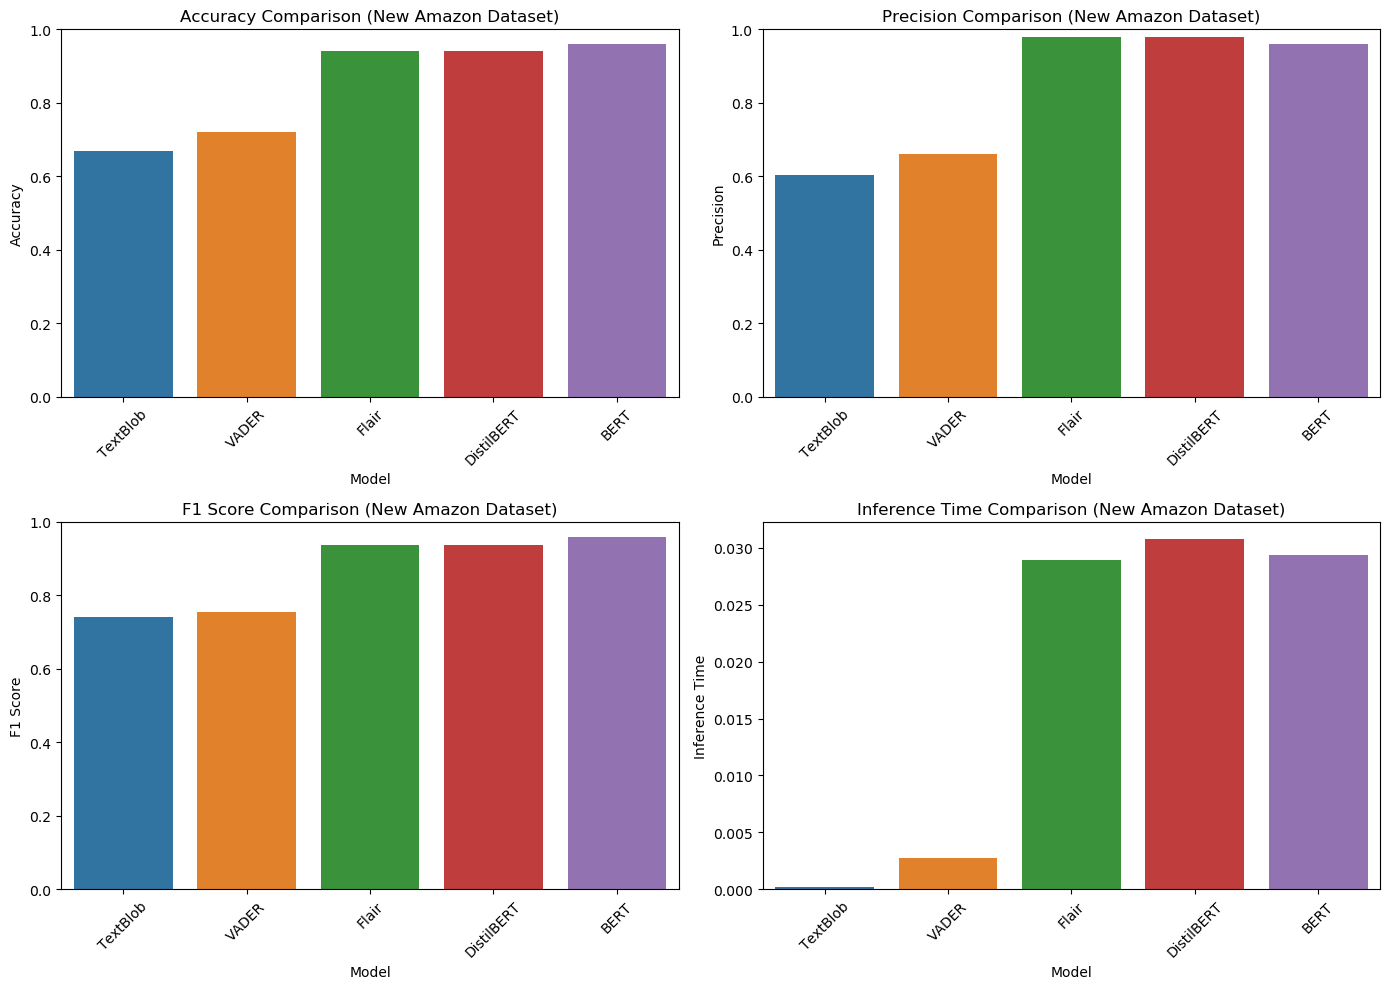

In [27]:
# Visualize results for the new dataset
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=new_comparison_df)
plt.title('Accuracy Comparison (New Amazon Dataset)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot precision
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=new_comparison_df)
plt.title('Precision Comparison (New Amazon Dataset)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot F1 Score
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='F1 Score', data=new_comparison_df)
plt.title('F1 Score Comparison (New Amazon Dataset)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot Inference Time
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Inference Time', data=new_comparison_df)
plt.title('Inference Time Comparison (New Amazon Dataset)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

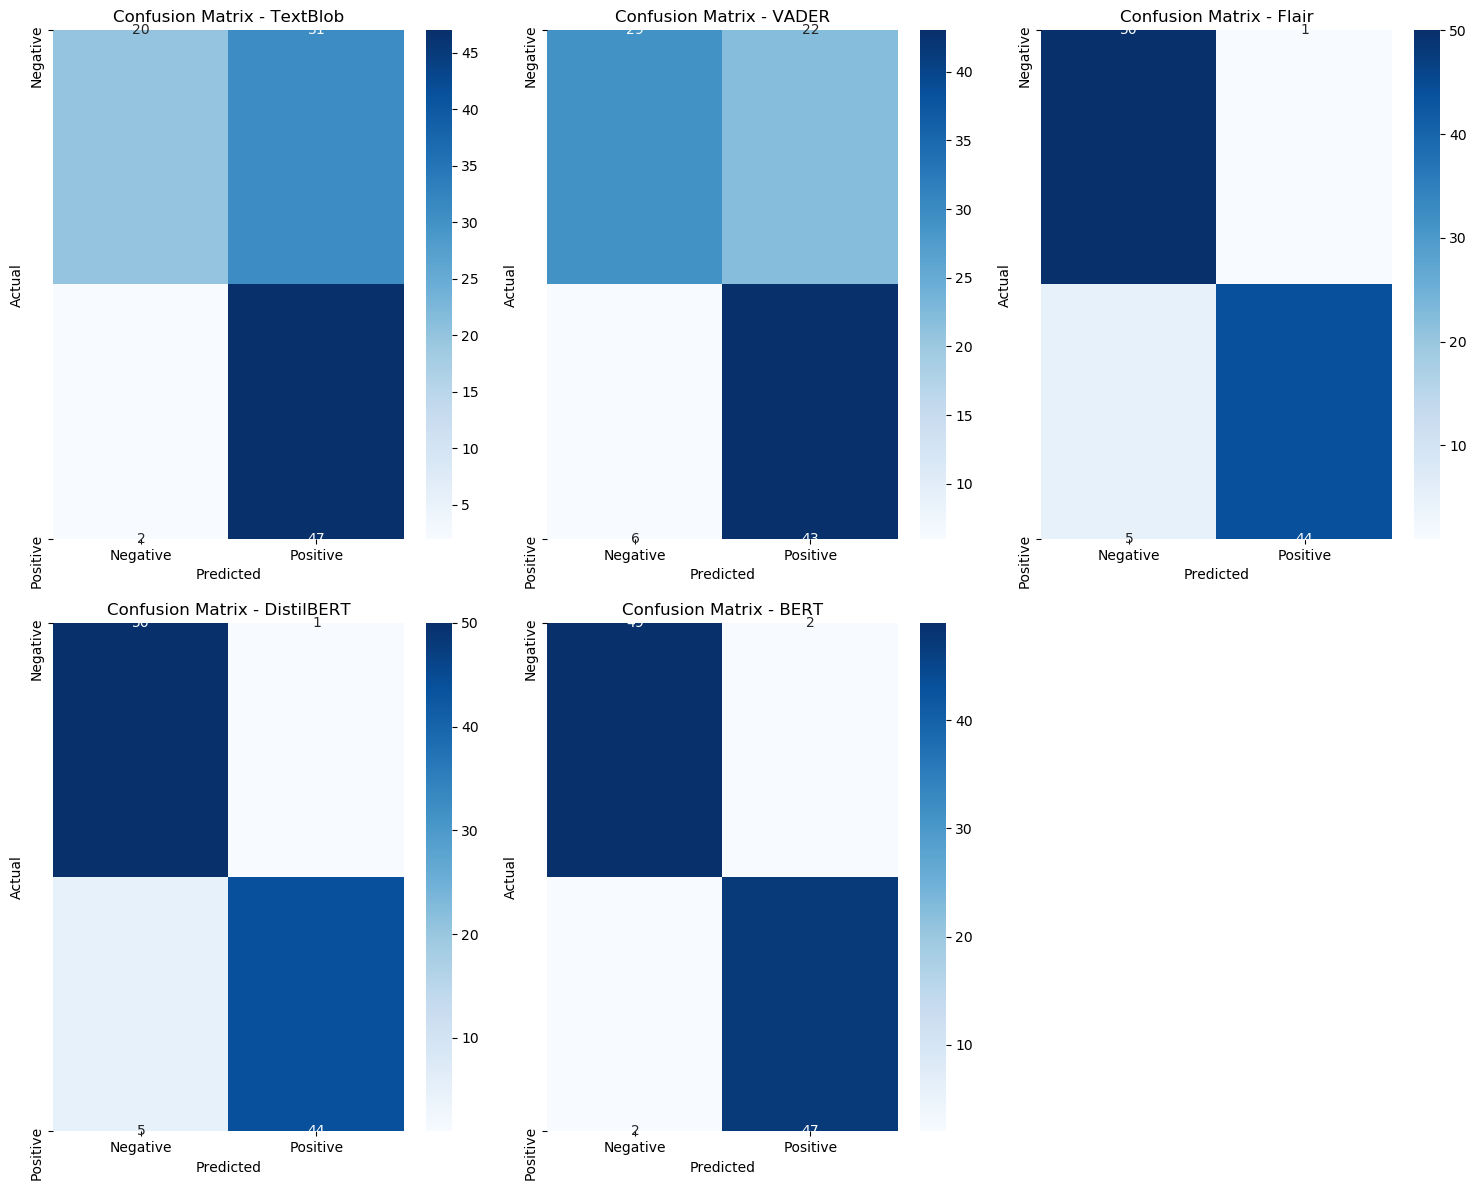

In [28]:
# Plot confusion matrices
plt.figure(figsize=(15, 12))
models = list(new_results.keys())

for i, model_name in enumerate(models):
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(new_amazon_sample['Label'], new_results[model_name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

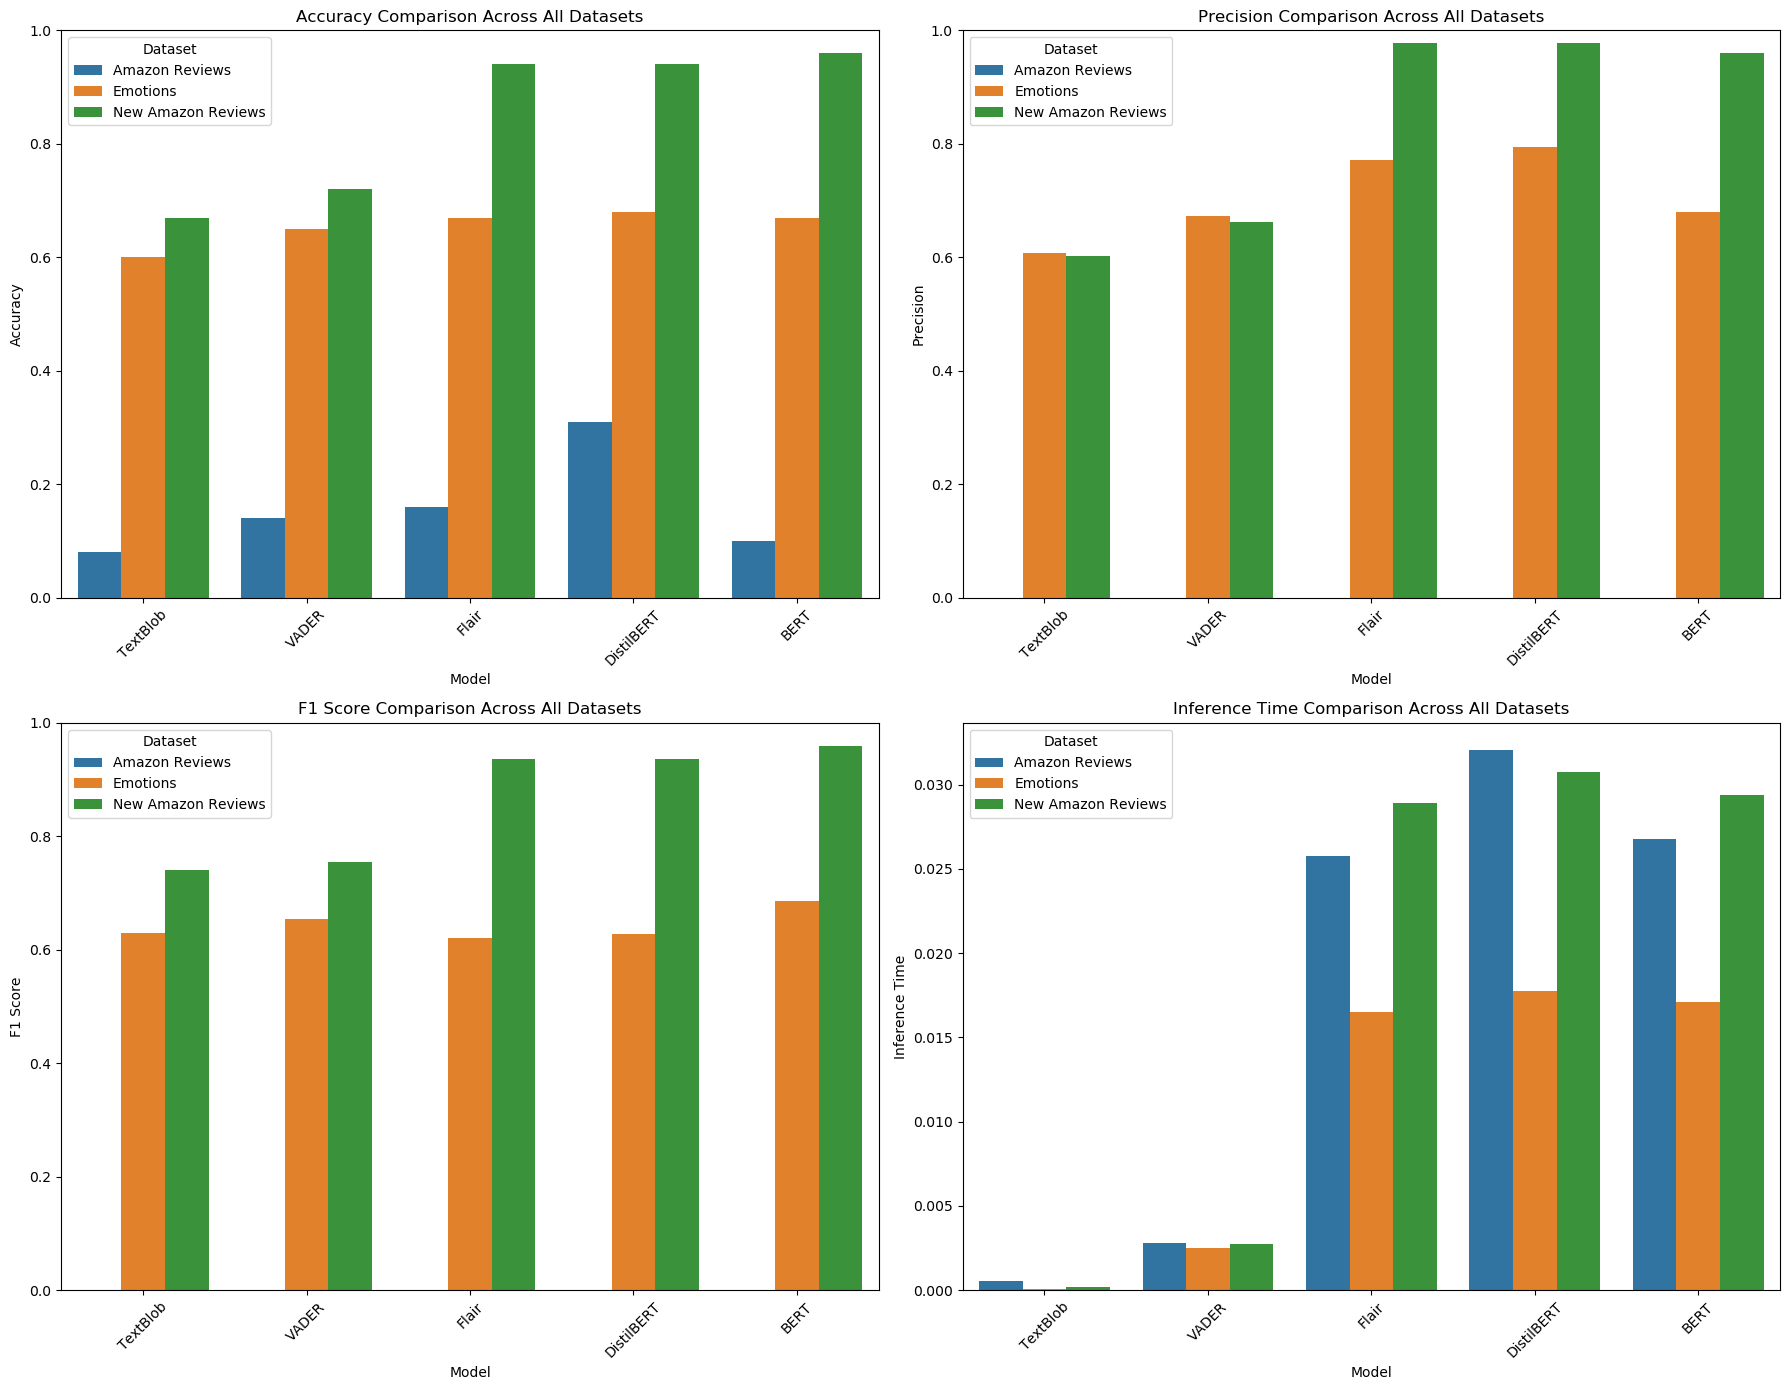

In [29]:
# Combine results from all three datasets for comparison
new_comparison_df['Dataset'] = 'New Amazon Reviews'
all_datasets_df = pd.concat([amazon_comparison_df, emotions_comparison_df, new_comparison_df])

# Create a figure for the combined comparison of all three datasets
plt.figure(figsize=(18, 14))

# Plot accuracy across all three datasets
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=all_datasets_df)
plt.title('Accuracy Comparison Across All Datasets')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot precision across all three datasets
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', hue='Dataset', data=all_datasets_df)
plt.title('Precision Comparison Across All Datasets')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot F1 Score across all three datasets
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='F1 Score', hue='Dataset', data=all_datasets_df)
plt.title('F1 Score Comparison Across All Datasets')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot Inference Time across all three datasets
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Inference Time', hue='Dataset', data=all_datasets_df)
plt.title('Inference Time Comparison Across All Datasets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [30]:
# Summary statistics for all three datasets
print("\nSummary of Model Performance Across All Datasets:")
all_summary = all_datasets_df.groupby(['Model', 'Dataset']).mean().reset_index()
print(all_summary[['Model', 'Dataset', 'Accuracy', 'Precision', 'F1 Score', 'Inference Time']])

# Calculate overall scores for the new dataset
new_comparison_df['Overall_Score'] = (
    new_comparison_df['Accuracy'] * 0.4 + 
    new_comparison_df['F1 Score'] * 0.4 + 
    (1 / (new_comparison_df['Inference Time'] + 0.01)) * 0.2  # Inverse of inference time
)

# Calculate overall scores for all datasets
all_datasets_df['Overall_Score'] = (
    all_datasets_df['Accuracy'] * 0.4 + 
    all_datasets_df['F1 Score'] * 0.4 + 
    (1 / (all_datasets_df['Inference Time'] + 0.01)) * 0.2  # Inverse of inference time
)


Summary of Model Performance Across All Datasets:
         Model             Dataset  Accuracy  Precision  F1 Score  \
0         BERT      Amazon Reviews      0.10   0.000000  0.000000   
1         BERT            Emotions      0.67   0.679245  0.685714   
2         BERT  New Amazon Reviews      0.96   0.959184  0.959184   
3   DistilBERT      Amazon Reviews      0.31   0.000000  0.000000   
4   DistilBERT            Emotions      0.68   0.794118  0.627907   
5   DistilBERT  New Amazon Reviews      0.94   0.977778  0.936170   
6        Flair      Amazon Reviews      0.16   0.000000  0.000000   
7        Flair            Emotions      0.67   0.771429  0.620690   
8        Flair  New Amazon Reviews      0.94   0.977778  0.936170   
9     TextBlob      Amazon Reviews      0.08   0.000000  0.000000   
10    TextBlob            Emotions      0.60   0.607143  0.629630   
11    TextBlob  New Amazon Reviews      0.67   0.602564  0.740157   
12       VADER      Amazon Reviews      0.14   0.000

In [31]:
# Get best model for each dataset
for dataset in all_datasets_df['Dataset'].unique():
    dataset_df = all_datasets_df[all_datasets_df['Dataset'] == dataset]
    best_idx = dataset_df['Overall_Score'].idxmax()
    best = all_datasets_df.iloc[best_idx]
    
    print(f"\nBest Model for {dataset}:")
    print(f"Model: {best['Model']}")
    print(f"Accuracy: {best['Accuracy']:.4f}")
    print(f"Precision: {best['Precision']:.4f}")
    print(f"F1 Score: {best['F1 Score']:.4f}")
    print(f"Inference Time: {best['Inference Time']:.4f} seconds")
    print(f"Overall Score: {best['Overall_Score']:.4f}")

# Compare performance consistency across datasets
print("\nPerformance Consistency Analysis:")
model_consistency = all_datasets_df.groupby('Model')[['Accuracy', 'F1 Score']].agg(['mean', 'std'])
print(model_consistency)


Best Model for Amazon Reviews:
Model: TextBlob
Accuracy: 0.0800
Precision: 0.0000
F1 Score: 0.0000
Inference Time: 0.0006 seconds
Overall Score: 18.9761

Best Model for Emotions:
Model: TextBlob
Accuracy: 0.0800
Precision: 0.0000
F1 Score: 0.0000
Inference Time: 0.0006 seconds
Overall Score: 18.9761

Best Model for New Amazon Reviews:
Model: TextBlob
Accuracy: 0.0800
Precision: 0.0000
F1 Score: 0.0000
Inference Time: 0.0006 seconds
Overall Score: 18.9761

Performance Consistency Analysis:
            Accuracy            F1 Score          
                mean       std      mean       std
Model                                             
BERT        0.576667  0.437531  0.548299  0.494136
DistilBERT  0.643333  0.316596  0.521359  0.477093
Flair       0.590000  0.396106  0.518953  0.476305
TextBlob    0.450000  0.322335  0.456596  0.399267
VADER       0.503333  0.316596  0.469284  0.409532


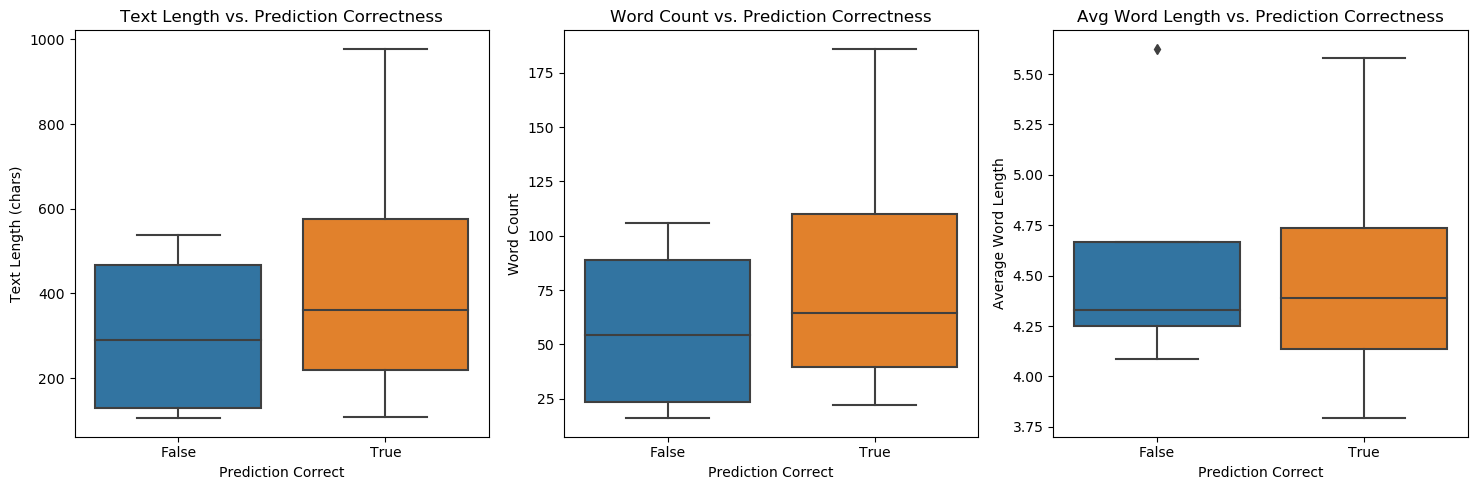

In [32]:
# Further analysis - Feature importance for the new dataset
# We'll analyze what characteristics in the text most strongly correlate with correct/incorrect predictions

# Choose the best model based on F1 score for this analysis
best_model_name = new_comparison_df.loc[new_comparison_df['F1 Score'].idxmax(), 'Model']
best_predictions = new_results[best_model_name]

# Add prediction correctness
new_amazon_sample['prediction_correct'] = (new_amazon_sample['Label'] == best_predictions)

# Calculate text statistics that might influence prediction accuracy
new_amazon_sample['text_length'] = new_amazon_sample['Review'].apply(len)
new_amazon_sample['word_count'] = new_amazon_sample['Review'].apply(lambda x: len(x.split()))
new_amazon_sample['avg_word_length'] = new_amazon_sample['Review'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0
)

# Analyze relationship between text characteristics and prediction correctness
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='prediction_correct', y='text_length', data=new_amazon_sample)
plt.title('Text Length vs. Prediction Correctness')
plt.xlabel('Prediction Correct')
plt.ylabel('Text Length (chars)')

plt.subplot(1, 3, 2)
sns.boxplot(x='prediction_correct', y='word_count', data=new_amazon_sample)
plt.title('Word Count vs. Prediction Correctness')
plt.xlabel('Prediction Correct')
plt.ylabel('Word Count')

plt.subplot(1, 3, 3)
sns.boxplot(x='prediction_correct', y='avg_word_length', data=new_amazon_sample)
plt.title('Avg Word Length vs. Prediction Correctness')
plt.xlabel('Prediction Correct')
plt.ylabel('Average Word Length')

plt.tight_layout()
plt.show()

In [33]:
# Analysis of common misclassified samples
incorrect_predictions = new_amazon_sample[~new_amazon_sample['prediction_correct']]
print("\nAnalysis of Misclassified Samples:")
print(f"Number of misclassified samples: {len(incorrect_predictions)}")

if len(incorrect_predictions) > 0:
    print("\nExamples of misclassified reviews:")
    for i, (idx, row) in enumerate(incorrect_predictions.head(5).iterrows()):
        print(f"\nMisclassified Example {i+1}:")
        print(f"Review: {row['Review'][:200]}...")
        print(f"True Label: {'Positive' if row['Label'] == 1 else 'Negative'}")
        print(f"Predicted Label: {'Positive' if best_predictions[idx] == 1 else 'Negative'}")
        
    # Most common words in misclassified negative reviews predicted as positive
    false_positives = incorrect_predictions[incorrect_predictions['Label'] == 0]
    if len(false_positives) > 0:
        fp_text = ' '.join(false_positives['Review'].tolist())
        fp_words = [word.lower() for word in fp_text.split() if len(word) > 3]
        fp_word_counts = pd.Series(fp_words).value_counts().head(20)
        
        print("\nMost common words in false positives (negative reviews classified as positive):")
        print(fp_word_counts)
    
    # Most common words in misclassified positive reviews predicted as negative
    false_negatives = incorrect_predictions[incorrect_predictions['Label'] == 1]
    if len(false_negatives) > 0:
        fn_text = ' '.join(false_negatives['Review'].tolist())
        fn_words = [word.lower() for word in fn_text.split() if len(word) > 3]
        fn_word_counts = pd.Series(fn_words).value_counts().head(20)
        
        print("\nMost common words in false negatives (positive reviews classified as negative):")
        print(fn_word_counts)


Analysis of Misclassified Samples:
Number of misclassified samples: 4

Examples of misclassified reviews:

Misclassified Example 1:
Review: second time's the charm: The first week after i got it it worked wonders. Then the person you were talking to couldn't here you. I called the tech support line and they triend to figure out what was w...
True Label: Positive
Predicted Label: Negative

Misclassified Example 2:
Review: The product review is a lie: There is NO adjustable shoulder strap. The unit itself is ok but not great. It's compact and stylish which is nice. The pocket for the extra battery has no padding or anyt...
True Label: Negative
Predicted Label: Positive

Misclassified Example 3:
Review: canera case: Great sturdy case for my sony camera!! Love the color and also matches my pink camera but good for my silver camera as well....
True Label: Negative
Predicted Label: Positive

Misclassified Example 4:
Review: Provocative: Disturbing yet provacative. Reading this opinion has m

In [34]:
# Comparison of computational resources across models
print("\nComputational Resource Comparison:")
for model_name in all_datasets_df['Model'].unique():
    model_data = all_datasets_df[all_datasets_df['Model'] == model_name]
    avg_time = model_data['Inference Time'].mean()
    min_time = model_data['Inference Time'].min()
    max_time = model_data['Inference Time'].max()
    
    print(f"\n{model_name}:")
    print(f"  Average inference time: {avg_time:.4f} seconds")
    print(f"  Range: {min_time:.4f} - {max_time:.4f} seconds")
    
    # Estimated time for processing the full 400k dataset
    est_full_time = avg_time * 400000 / 60 / 60  # hours
    print(f"  Estimated time to process full 400k dataset: {est_full_time:.2f} hours")


Computational Resource Comparison:

TextBlob:
  Average inference time: 0.0003 seconds
  Range: 0.0001 - 0.0006 seconds
  Estimated time to process full 400k dataset: 0.03 hours

VADER:
  Average inference time: 0.0027 seconds
  Range: 0.0025 - 0.0028 seconds
  Estimated time to process full 400k dataset: 0.30 hours

Flair:
  Average inference time: 0.0237 seconds
  Range: 0.0165 - 0.0289 seconds
  Estimated time to process full 400k dataset: 2.64 hours

DistilBERT:
  Average inference time: 0.0269 seconds
  Range: 0.0177 - 0.0321 seconds
  Estimated time to process full 400k dataset: 2.98 hours

BERT:
  Average inference time: 0.0244 seconds
  Range: 0.0171 - 0.0294 seconds
  Estimated time to process full 400k dataset: 2.71 hours
